In [2]:
# This notebook uses the published version of the SNEMO eigenvectors and fits to the SNfactory data
# to generate KDEs
import os
import copy
import pickle
import sncosmo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from snemo_gen import DATADIR
from astropy.io import ascii
from astropy.cosmology import WMAP9 as cosmo
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from matplotlib.ticker import StrMethodFormatter

In [3]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 16

# Load fits from Saunders et al. 2018

The data can be found on the [SNEMO webpage](https://snfactory.lbl.gov/snemo/)

In [4]:
fits_path = os.path.join(DATADIR, 'anon_snf_fits_published_snemo_and_salt.csv')
fits = pd.read_csv(fits_path, index_col=0)

In [5]:
fits.head()

,z_helio,SALT2_x0,SALT2_x0_err,SALT2_x1,SALT2_x1_err,SALT2_c,SALT2_c_err,SALT2_mbstar,SALT2_MB191,SNEMO2_c0,...,SNEMO15_c11,SNEMO15_c11_err,SNEMO15_c12,SNEMO15_c12_err,SNEMO15_c13,SNEMO15_c13_err,SNEMO15_c14,SNEMO15_c14_err,SNEMO15_mbstar,SNEMO15_MB191
anon_name,,,,,,,,,,,,,,,,,,,,,
SN000,0.076927,0.000762,1.732040e-06,0.083247,0.012107,-0.052688,0.001535,18.300040,-0.311404,7.148334e-17,...,-0.151134,0.076176,0.959638,0.097107,0.319279,0.095270,1.485078,0.118991,18.325573,-0.285872
SN001,0.025047,0.002739,1.117447e-06,-0.195855,0.001538,0.309248,0.000282,16.906036,0.812262,8.754392e-16,...,-0.433452,0.012895,-3.028935,0.012860,-2.075116,0.013659,-0.748300,0.020434,16.937181,0.843408
SN002,0.067370,0.001015,6.841256e-07,0.383614,0.003812,-0.060768,0.000506,17.989741,-0.319163,8.773060e-17,...,1.442487,0.029791,-0.898052,0.029438,0.296780,0.031840,1.414718,0.045475,17.969958,-0.338946
SN003,0.081444,0.000782,2.185247e-06,0.913483,0.013092,-0.046332,0.001958,18.272124,-0.469997,7.319269e-17,...,0.133107,0.092593,-1.173614,0.113397,-2.941654,0.117884,2.009391,0.160080,18.336388,-0.405733
SN004,0.010187,0.042914,3.735027e-06,0.572055,0.000364,0.115399,0.000061,13.923158,-0.192702,7.317423e-15,...,-0.744413,0.002650,4.378012,0.002738,0.935869,0.003144,-0.890721,0.003508,13.980270,-0.135590


In [6]:
len(fits)

216

In [7]:
fits.columns

Index(['z_helio', 'SALT2_x0', 'SALT2_x0_err', 'SALT2_x1', 'SALT2_x1_err',
       'SALT2_c', 'SALT2_c_err', 'SALT2_mbstar', 'SALT2_MB191', 'SNEMO2_c0',
       'SNEMO2_c0_err', 'SNEMO2_As', 'SNEMO2_As_err', 'SNEMO2_c1',
       'SNEMO2_c1_err', 'SNEMO2_mbstar', 'SNEMO2_MB191', 'SNEMO7_c0',
       'SNEMO7_c0_err', 'SNEMO7_As', 'SNEMO7_As_err', 'SNEMO7_c1',
       'SNEMO7_c1_err', 'SNEMO7_c2', 'SNEMO7_c2_err', 'SNEMO7_c3',
       'SNEMO7_c3_err', 'SNEMO7_c4', 'SNEMO7_c4_err', 'SNEMO7_c5',
       'SNEMO7_c5_err', 'SNEMO7_c6', 'SNEMO7_c6_err', 'SNEMO7_mbstar',
       'SNEMO7_MB191', 'SNEMO15_c0', 'SNEMO15_c0_err', 'SNEMO15_As',
       'SNEMO15_As_err', 'SNEMO15_c1', 'SNEMO15_c1_err', 'SNEMO15_c2',
       'SNEMO15_c2_err', 'SNEMO15_c3', 'SNEMO15_c3_err', 'SNEMO15_c4',
       'SNEMO15_c4_err', 'SNEMO15_c5', 'SNEMO15_c5_err', 'SNEMO15_c6',
       'SNEMO15_c6_err', 'SNEMO15_c7', 'SNEMO15_c7_err', 'SNEMO15_c8',
       'SNEMO15_c8_err', 'SNEMO15_c9', 'SNEMO15_c9_err', 'SNEMO15_c10',
       'SNEMO15

# Examine distributions

In [8]:
def get_data(model_name):
    model = sncosmo.Model(source=model_name)
    df = pd.DataFrame()
    for i, param_name in enumerate(model.source.param_names):
        df[param_name] = fits['{}_{}'.format(model_name.upper(), param_name)]
    df['MB'] = fits[model_name.upper()+'_MB191']
    df['z'] = fits['z_helio']
    return df

In [9]:
def plot_coefs(df, model_name):
    model = sncosmo.Model(source=model_name)
    nparams = len(model.source.param_names)
    plt.figure(figsize=(12, 12))
    for i, param_name_1 in enumerate(model.source.param_names):
        for j, param_name_2 in enumerate(model.source.param_names):
            if i>j: continue
            plt.subplot(nparams, nparams, i+j*nparams+1)
            if i==0: param_name_1 = 'MB'
            if j==0: param_name_2 = 'MB'
            if i==j:
                plt.hist(df[param_name_1])
            else:
                plt.scatter(df[param_name_1], df[param_name_2], s=3)
            if i==0:
                plt.ylabel(param_name_2)
            else:
                plt.yticks([])
            if j==nparams-1:
                plt.xlabel(param_name_1)
            else:
                plt.xticks([])

## SALT2

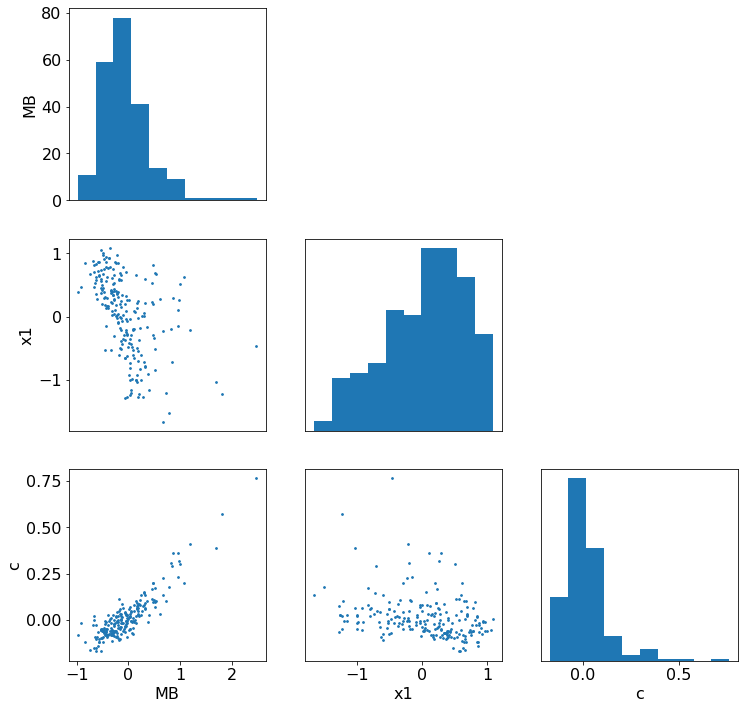

In [112]:
df = get_data('salt2')
plot_coefs(df, 'salt2')

## SNEMO2

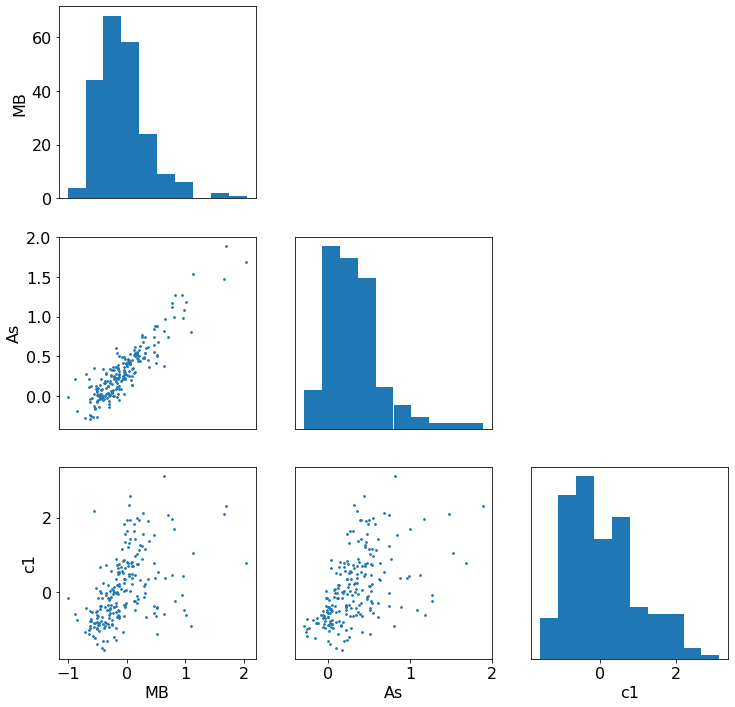

In [113]:
df = get_data('snemo2')
plot_coefs(df, 'snemo2')

## SNEMO7

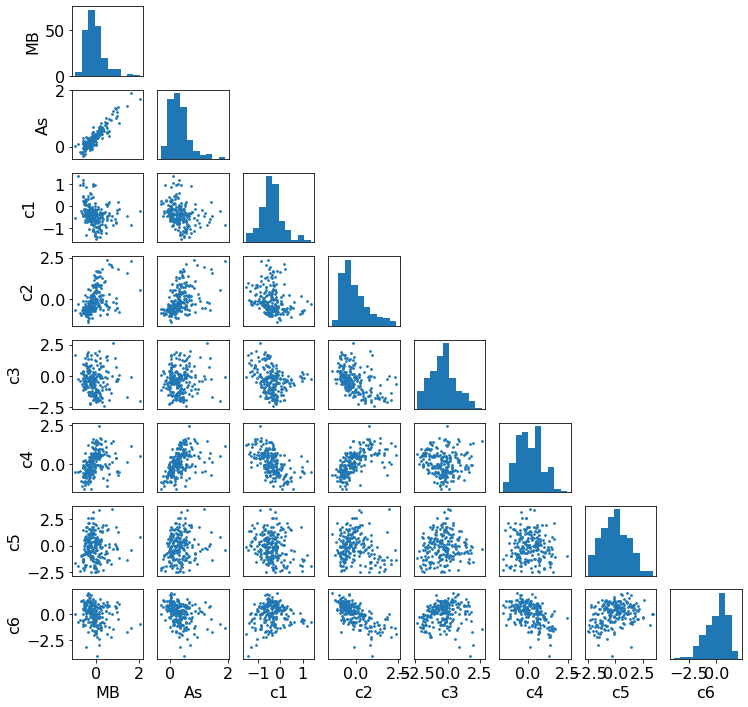

In [114]:
df = get_data('snemo7')
plot_coefs(df, 'snemo7')

## SNEMO15

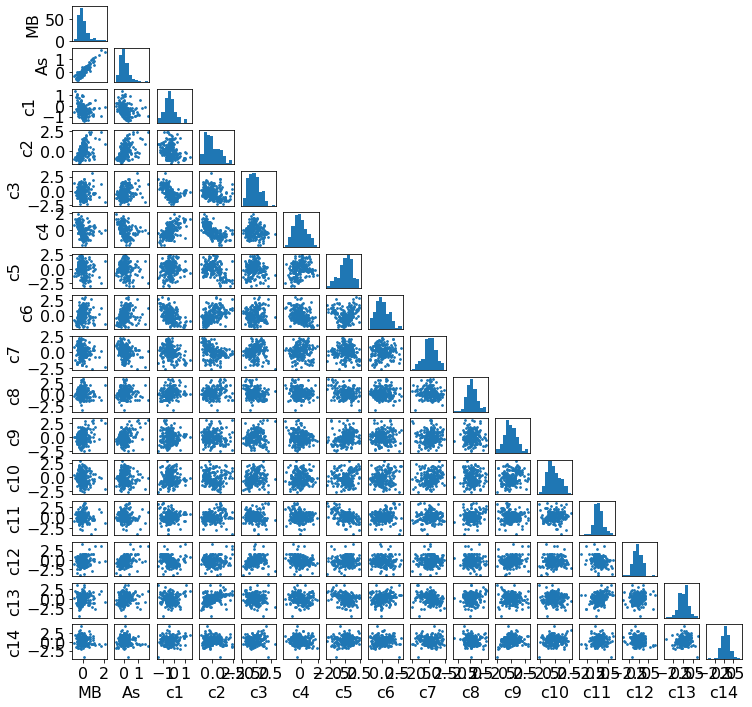

In [115]:
df = get_data('snemo15')
plot_coefs(df, 'snemo15')

# Train KDEs

In [122]:
def mod_data(model_name, samples):
    model = sncosmo.Model(source=model_name)
    df = get_data(model_name)
    if model_name == 'salt2':
        for i, param_name in enumerate(['MB', 'c', 'x1']):
            df['sample_'+param_name] = [s[i] for s in samples]
    else:
        for i, param_name in enumerate(model.source.param_names):
            if i==0: param_name = 'MB'
            df['sample_'+param_name] = [s[i] for s in samples]
    return df

In [123]:
def plot_samples(df, model_name, save=True):
    model = sncosmo.Model(source=model_name)
    nparams = len(model.source.param_names)
    plt.figure(figsize=(3*len(model.source.parameters), 3*len(model.source.parameters)))
    for i, param_name_1 in enumerate(model.source.param_names):
        for j, param_name_2 in enumerate(model.source.param_names):
            if i > j: continue
            plt.subplot(nparams, nparams, i+j*nparams+1)
            if i==0:
                label_1 = 'M_B + 19.1'
                param_name_1 = 'MB'
            else:
                label_1 = model.source.param_names_latex[i]
            if j==0:
                label_2 = 'M_B + 19.1'
                param_name_2 = 'MB'
            else:
                label_2 = model.source.param_names_latex[j]
            if i==j:
                plt.hist([df[param_name_1], df['sample_'+param_name_1]], color=['C0', 'C3'],
                         histtype='step', cumulative=False, density=True, bins=25, linewidth=2,
                         label=['Data', 'KDE samples'])
            else:
                plt.scatter(df[param_name_1], df[param_name_2], s=10, alpha=0.5)
                plt.scatter(df['sample_'+param_name_1].dropna(), df['sample_'+param_name_2].dropna(),
                            c='C3', s=10, alpha=0.5)
            if i==0:
                plt.ylabel('${}$'.format(label_2), fontsize=24)
                plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))
            else:
                plt.yticks([])
            if j==nparams-1:
                plt.xlabel('${}$'.format(label_1), fontsize=24)
                plt.xticks(rotation=90)
                plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))
            else:
                plt.xticks([])
    ax = plt.gca()
    legend_loc = {'salt2': (1, 3.2),
                  'snemo2': (1, 3.2),
                  'snemo7': (1, 8),
                  'snemo15': (1, 19)}
    fontsize = {'salt2': 24,
                'snemo2': 24,
                'snemo7': 32,
                'snemo15': 64}
    ax.legend(bbox_to_anchor=legend_loc[model_name], fontsize=fontsize[model_name])
    if save:
        path = '../figures/{}_corner.pdf'.format(model_name)
        plt.savefig(path, bbox_inches='tight')

In [124]:
def calc_kde(model_name):
    df = get_data(model_name)
    if 'snemo' in model_name.lower():
        coefs = df[['MB', 'As']+['c'+str(i) for i in range(1, int(model_name[5:]))]].values
    else:
        coefs = df[['MB', 'c', 'x1']]
    v, l, vinv = np.linalg.svd(np.cov(coefs.T))
    rescaled_coefs = (np.diag(1./np.sqrt(l)) @ vinv @ coefs.T).T
    
    params = {'bandwidth': np.logspace(-1, 1, 100)}
    grid = GridSearchCV(KernelDensity(), params, cv=3, iid=True)
    grid.fit(rescaled_coefs)
    kde = grid.best_estimator_
    return kde, v, l, grid

In [125]:
def sample_kde(n, kde, v, l):
    unscaled_samples = kde.sample(n, random_state=0)
    samples = (v @ np.diag(np.sqrt(l)) @ unscaled_samples.T).T
    return samples

## SALT2

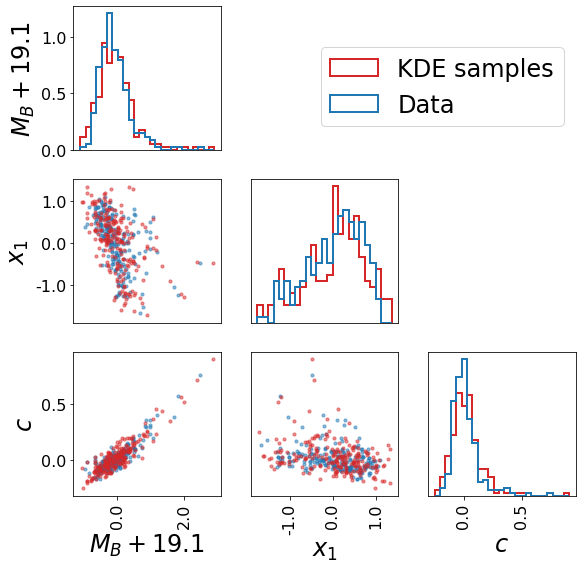

In [126]:
model_name = 'salt2'
kde, v, l, grid = calc_kde(model_name)
samples = sample_kde(216, kde, v, l)
df = mod_data(model_name, samples)
plot_samples(df, model_name)

## SNEMO2

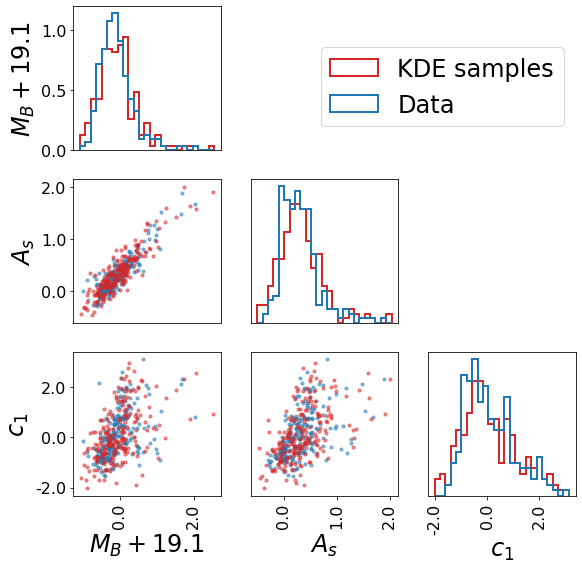

In [127]:
model_name = 'snemo2'
kde, v, l, grid = calc_kde(model_name)
samples = sample_kde(216, kde, v, l)
df = mod_data(model_name, samples)
plot_samples(df, model_name)

## SNEMO7

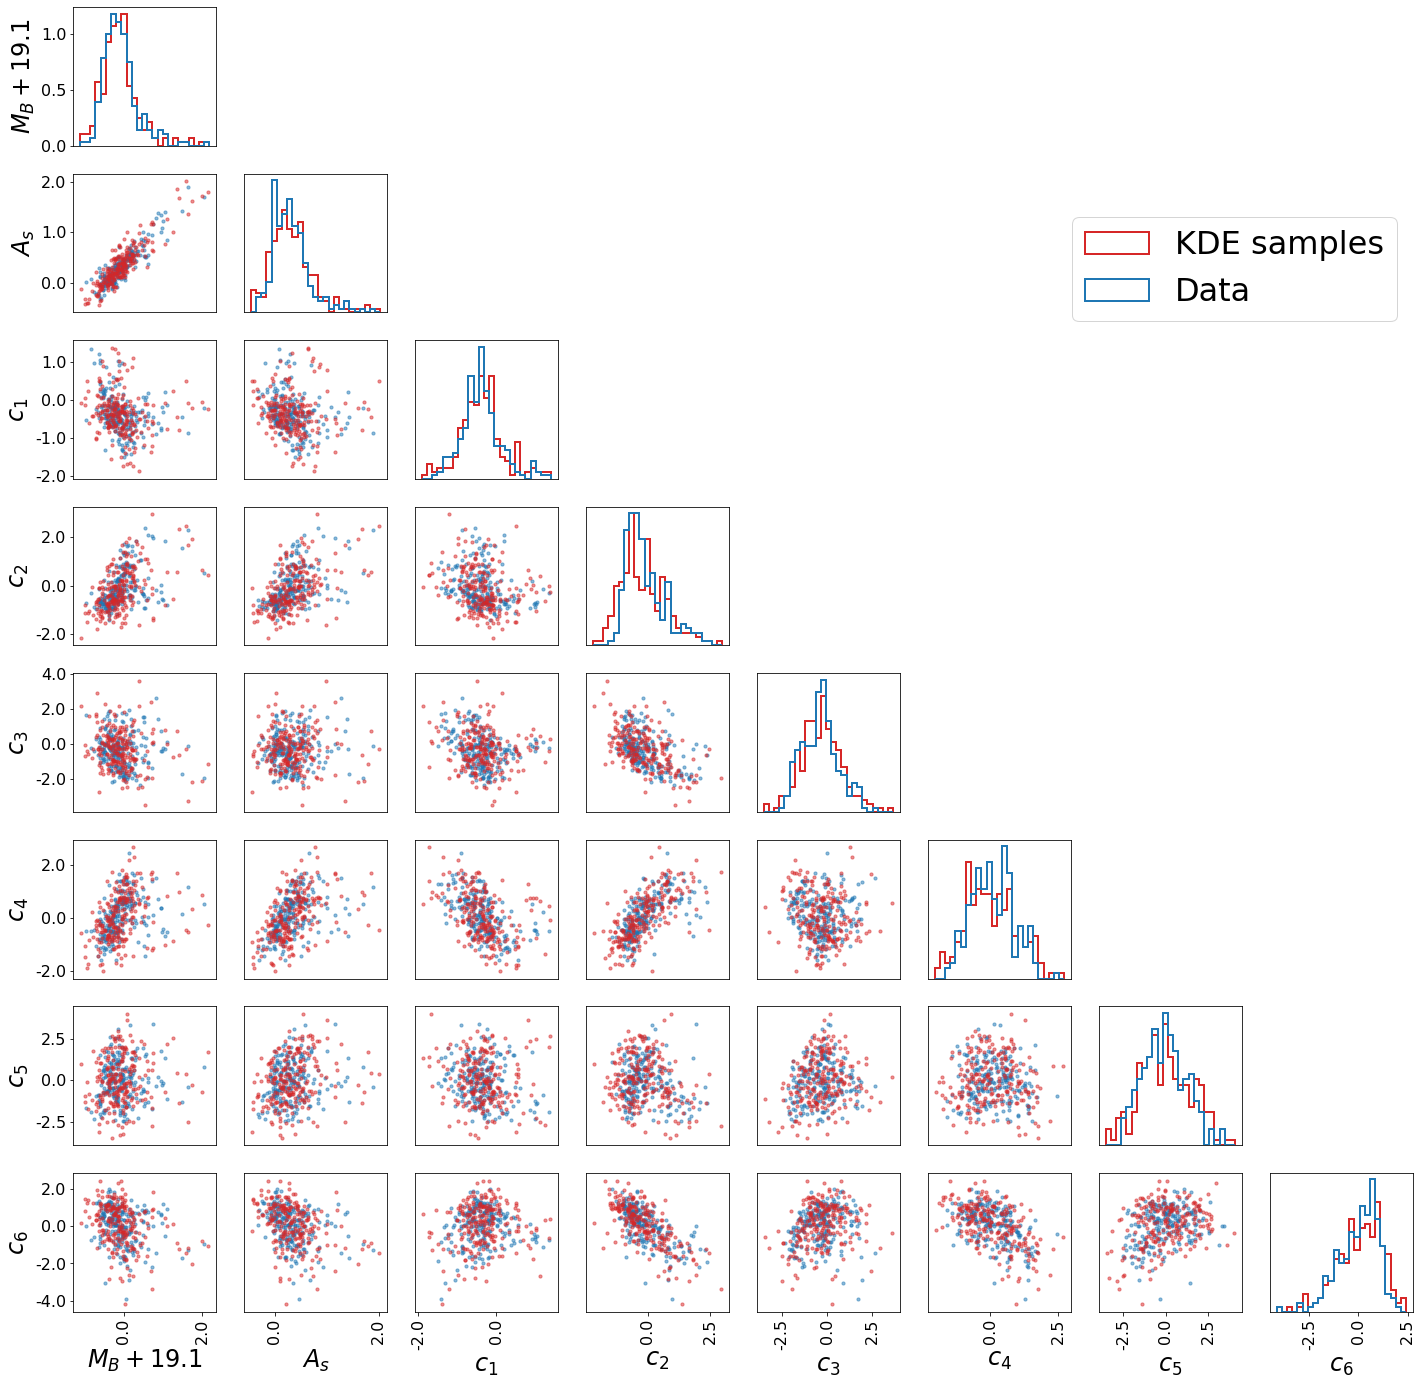

In [128]:
model_name = 'snemo7'
kde, v, l, grid = calc_kde(model_name)
samples = sample_kde(216, kde, v, l)
df = mod_data(model_name, samples)
plot_samples(df, model_name)

## SNEMO15

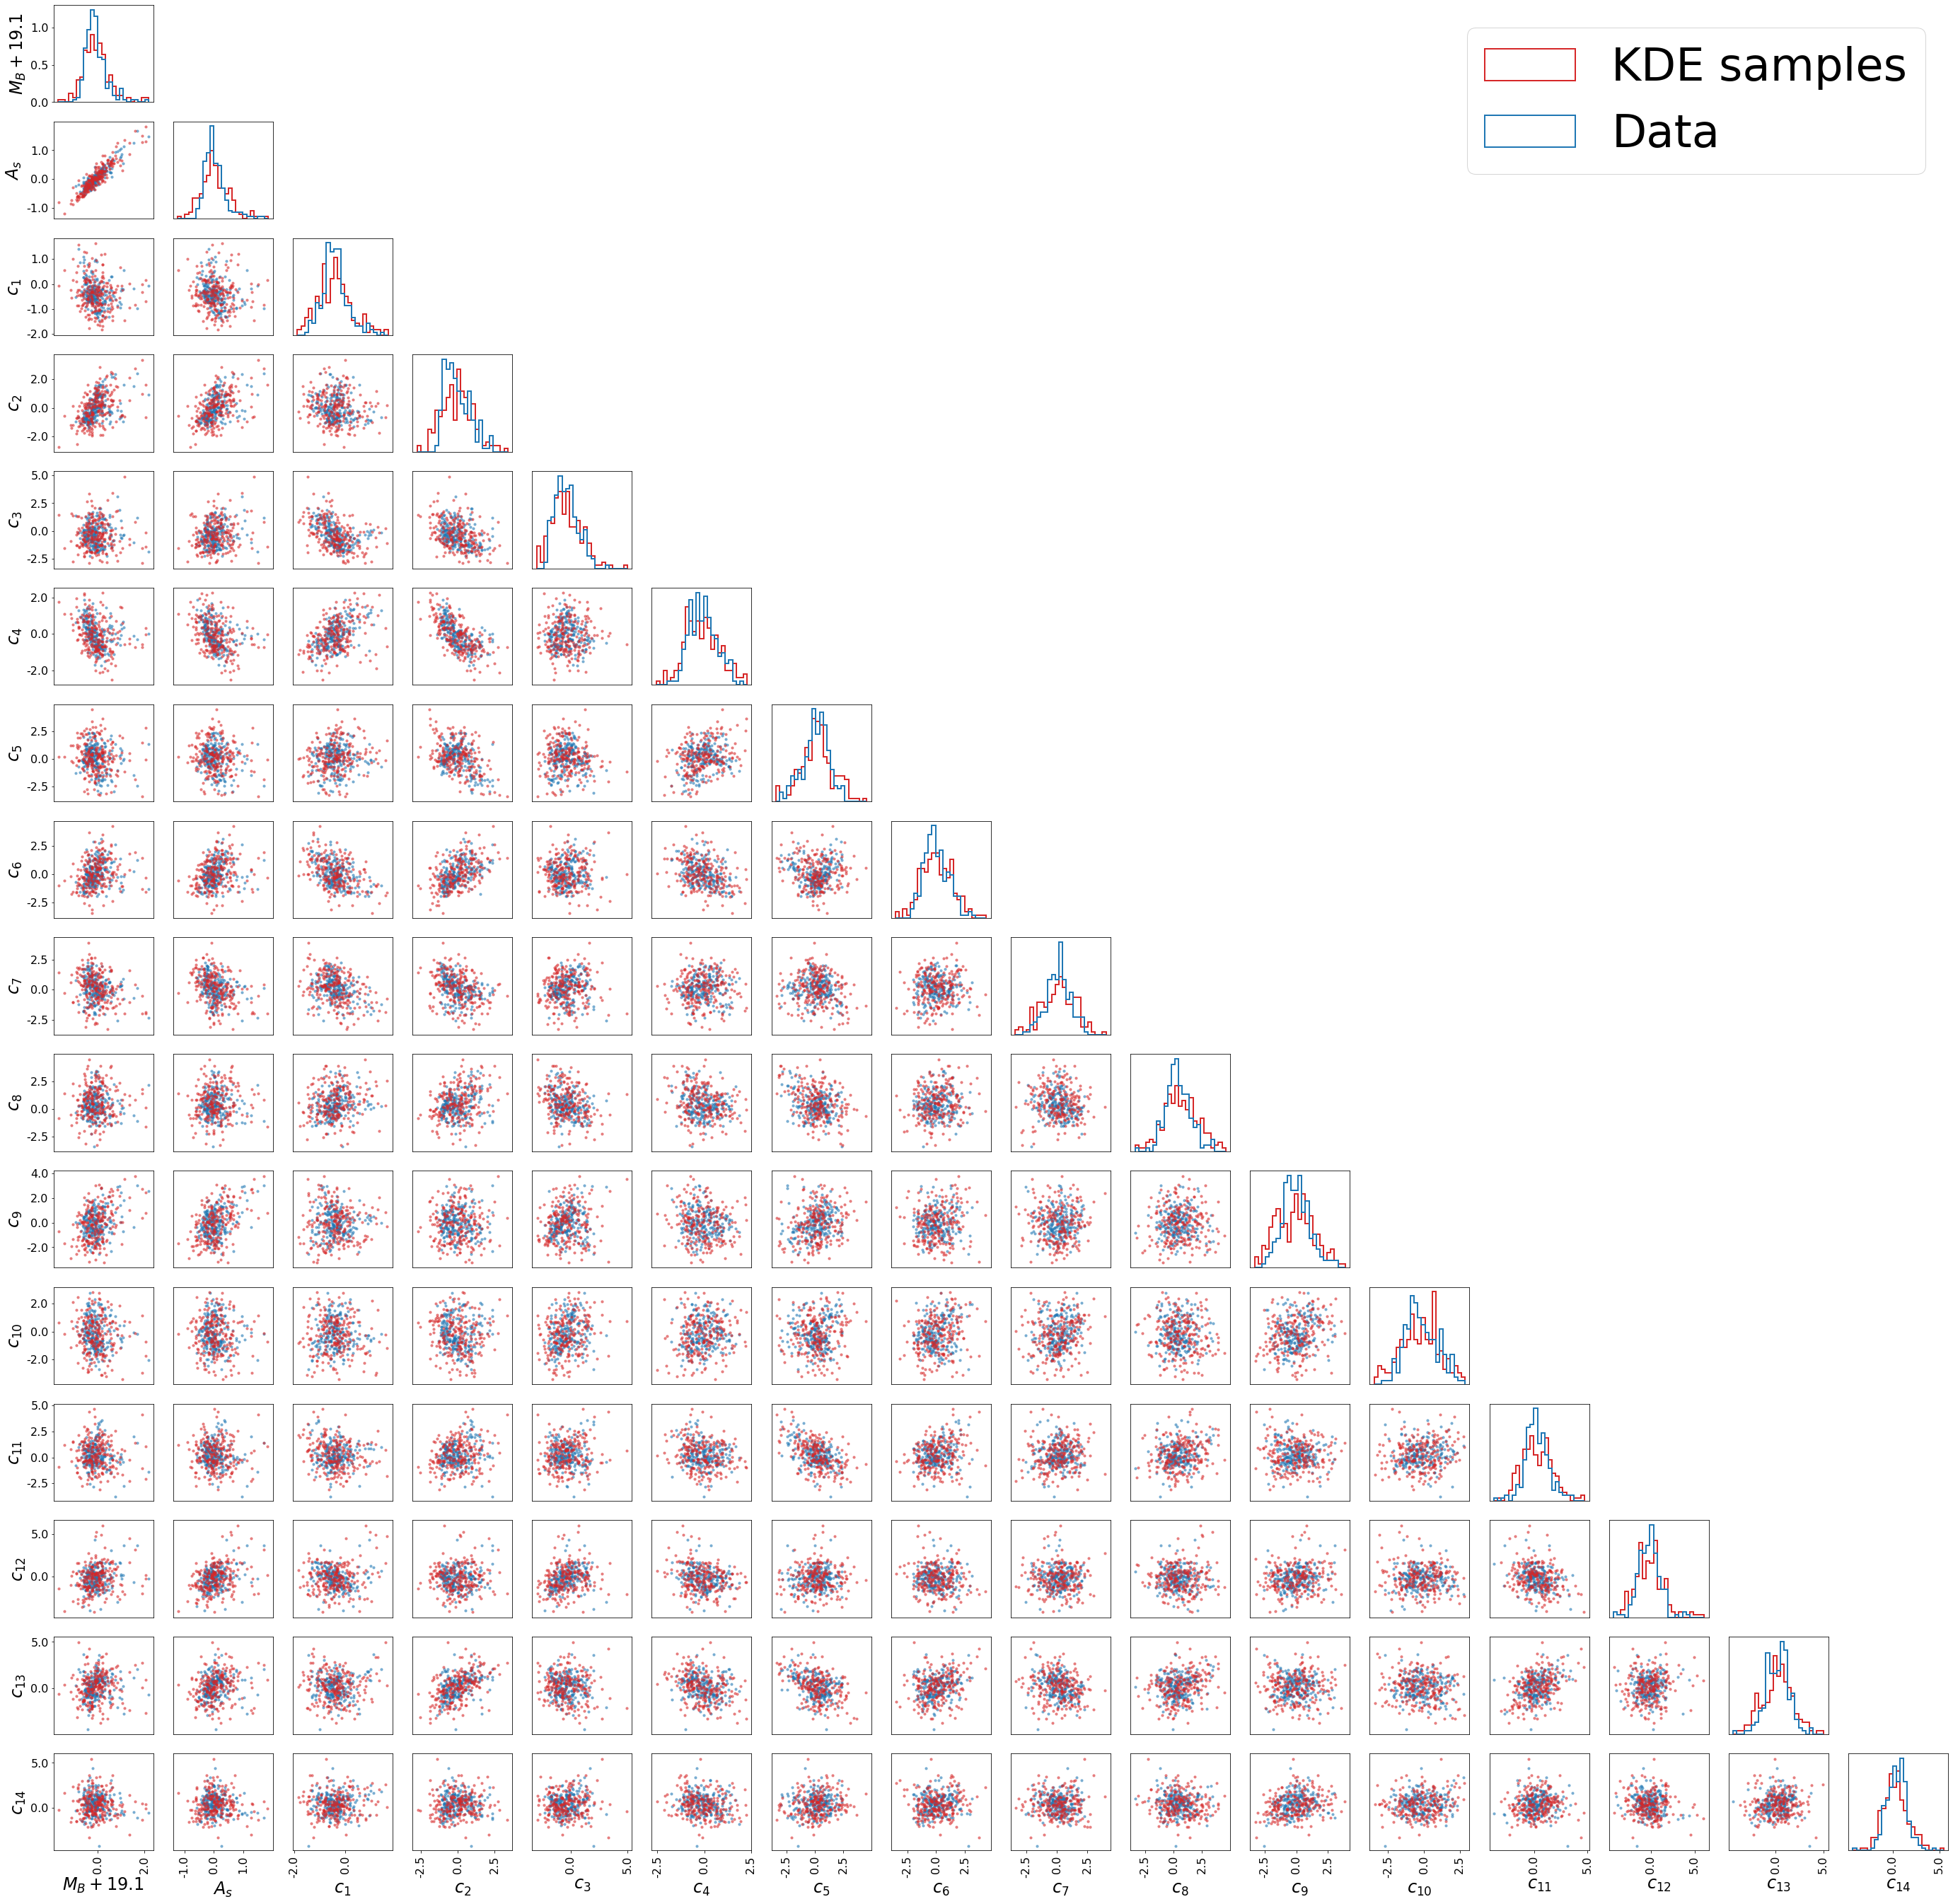

In [129]:
model_name = 'snemo15'
kde, v, l, grid = calc_kde(model_name)
samples = sample_kde(216, kde, v, l)
df = mod_data(model_name, samples)
plot_samples(df, model_name)

# Save KDEs

In [130]:
for model_name in ['salt2', 'snemo2', 'snemo7', 'snemo15']:
    print(model_name)
    kde, v, l, grid = calc_kde(model_name)
    pickle.dump(calc_kde(model_name),
                open(os.path.join(DATADIR, '{}_KDE_published.pkl'.format(model_name), 'wb'))

salt2
snemo2
snemo7
snemo15


# Generating new objects

Text(0.5, 0, 'Wavelength ($\\AA$)')

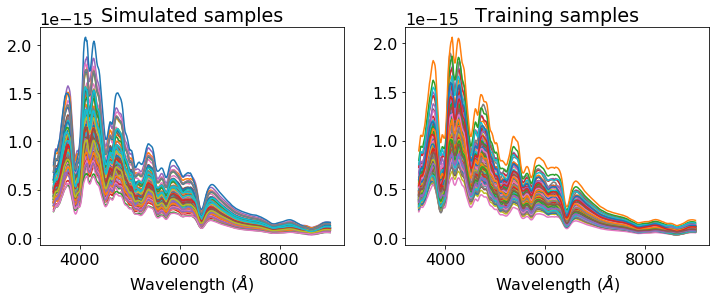

In [135]:
z = 0.05
model_name = 'snemo2'
model = sncosmo.Model(model_name)
kde, v, l, grid = calc_kde(model_name)
samples = sample_kde(100, kde, v, l)
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title('Simulated samples')
for sample in samples:
    model.set(**dict(zip(model.source.param_names[1:], sample[1:])))
    model.set(t0=0, z=z)
    model.set_source_peakabsmag(sample[0]-19.1, 'bessellb', 'ab')
    if model_name == 'salt2':
        model.set(c=0)
    else:
        model.set(As=0)
    wave = model.source._wave * (1+z)
    plt.plot(wave, model.flux(wave=wave, time=0))
plt.xlabel('Wavelength ($\AA$)')
df = get_data(model_name)
coefs = df[['MB']+model.source.param_names[1:]].values
plt.subplot(122)
plt.title('Training samples')
for sample in coefs:
    model.set(**dict(zip(model.source.param_names[1:], sample[1:])))
    model.set(t0=0, z=z)
    model.set_source_peakabsmag(sample[0]-19.1, 'bessellb', 'ab')
    if model_name == 'salt2':
        model.set(c=0)
    else:
        model.set(As=0)
    wave = model.source._wave * (1+z)
    plt.plot(wave, model.flux(wave=wave, time=0))
plt.xlabel('Wavelength ($\AA$)')